In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# A toy problem

In [2]:
sig1=1
sig2=0.75
mu1=1.85
mu2=1
rho=0.82
means=np.array([mu1, mu2])
cov = np.array([
    [sig1**2, sig1*sig2*rho],
    [sig2*sig1*rho, sig2**2]
])
means, cov

(array([1.85, 1.  ]), array([[1.    , 0.615 ],
        [0.615 , 0.5625]]))

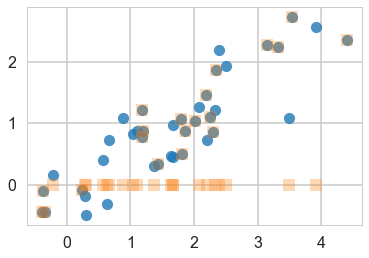

In [4]:
samples=np.random.multivariate_normal(means, cov, size=40)
samples_censored=np.copy(samples)
samples_censored[20:,1]=0
plt.plot(samples[:,0], samples[:,1], 'o', alpha=0.8)
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', alpha=0.3)

If we have all data

In [5]:
mu1 = lambda s: np.mean(s[:,0])
mu2 = lambda s: np.mean(s[:,1])
s1 = lambda s: np.std(s[:,0])
s2 = lambda s: np.std(s[:,1])
rho = lambda s: np.mean((s[:,0] - mu1(s))*(s[:,1] - mu2(s)))/(s1(s)*s2(s))


But we don't. So we shall follow an iterative process to find them

In [6]:
mu1s=[]
mu2s=[]
s1s=[]
s2s=[]
rhos=[]

Bur remember our data are missing in the y-direction. Assume 0 and go. Since we are using the MLE of the full-data likelihood, with this assumption we can use the MLE formulae. This is called M-step or maximization step since we used the MLE formulae

In [7]:
# sample censored is missing data
mu1s.append(mu1(samples_censored))
mu2s.append(mu2(samples_censored))
s1s.append(s1(samples_censored))
s2s.append(s2(samples_censored))
rhos.append(rho(samples_censored))
mu1s,mu2s,s1s,s2s,rhos

([1.6403623850579812],
 [0.5131322003279545],
 [1.1765349423189515],
 [0.816189319922038],
 [0.6164216627118341])

In [8]:
def ynew(x, mu1, mu2, s1, s2, rho):
    return mu2 + rho*(s2/s1)*(x - mu1)
    

In [9]:
newys=ynew(samples_censored[20:,0], mu1s[0], mu2s[0], s1s[0], s2s[0], rhos[0])
newys

array([ 0.40070124,  1.30851984,  0.08029775,  0.52878136,  0.52316985,
        0.28084819, -0.06241081,  0.69740385,  0.09776136,  0.88356468,
        0.18736497,  0.83162831,  0.51319074,  0.80688464,  1.48553667,
        0.25915373,  0.05167605, -0.06708497,  0.75100444, -0.28273163])

In [10]:
for step in range(1,20):
    samples_censored[20:,1] = newys
    #M-step
    mu1s.append(mu1(samples_censored))
    mu2s.append(mu2(samples_censored))
    s1s.append(s1(samples_censored))
    s2s.append(s2(samples_censored))
    rhos.append(rho(samples_censored))
    #E-step
    newys=ynew(samples_censored[20:,0], mu1s[step], mu2s[step], s1s[step], s2s[step], rhos[step])
df=pd.DataFrame.from_dict(dict(mu1=mu1s, mu2=mu2s, s1=s1s, s2=s2s, rho=rhos))
df

,mu1,mu2,rho,s1,s2
0,1.640362,0.513132,0.616422,1.176535,0.816189
1,1.640362,0.745014,0.892833,1.176535,0.763792
2,1.640362,0.852181,0.944090,1.176535,0.787074
3,1.640362,0.902765,0.953743,1.176535,0.799584
4,1.640362,0.927099,0.955798,1.176535,0.803552
5,1.640362,0.939000,0.956229,1.176535,0.804246
6,1.640362,0.944900,0.956288,1.176535,0.804014
7,1.640362,0.947859,0.956270,1.176535,0.803653
8,1.640362,0.949356,0.956244,1.176535,0.803371
9,1.640362,0.950119,0.956225,1.176535,0.803186


Voila. We converge to stable values of our parameters.
But they may not be the ones we seeded the samples with. The Em algorithm is only good upto finding local minima, and a finite sample size also means that the minimum found can be slightly different.